<span style="font-size:10pt">Robotics & AI workshop @ PPU – June 2022 – Jean-Luc Charles (Jean-Luc.charles@ensam.eu) – CC BY-SA 4.0 – v1.0</span>

# Train/operate a Convolutional Neural Network (CNN) for the classification of handwritten digits images

<div class="alert alert-block alert-danger">
<span style="color:brown;font-family:arial;font-size:14pt"> 
It is important to use a <span style="font-weight:bold;">Python Virtual Environment</span> (PVE) for main Python projects: a PVE makes it possible to control for each project the versions of the Python interpreter and the "sensitive" modules (like tensorflow).</span></div>

All the notebooks in this directory must be loaded into a `jupyter notebook` launched in the PVE <b><span style="color: rgb(200, 151, 102);" >pyml</span></b> specially created for the workshop.<br>
They must be worked in this order:
- `ML1_MNIST.ipynb`: check that the <b><span style="color: rgb(200, 151, 102);">pyml</span></b> EVP is fully operationnal, load and use the data from the MNIST database (images and labels).
- `ML2_DNN.ipynb`: build a Dense Neural Network, train it with data from the MNIST and evaluate its performance.
- `ML3_DNN_ipynb`: re-load a trained DNN and evaluate its performnce with MNIST test data.
- `ML4_CNN.ipynb`: build a Convolutional Neural Network, train it with the MNIST database, ebvaluate its performance and use it with test data.

**Targeted learning objectives**
- Learn how a convolutional neural network works.
- Know how to build a Convolutional Neural Network (CNN) using the **tendorflow** and **keras** modules.
- Know how to train a CNN to classify MNIST images.
- Knowing how to use the trained network.

# Convolutional Neural Networks (CNN)

## General principles

Convolutional Neural Networks (CNN) offer particularly effective structures for analyzing the content of images. For this, the CNN implement specific processing and architecture:
- the extraction of features from images using **convolutional filters**,
- the reduction with **pooling filters** of the amount of information generated by the numerous convolution filters,
- an architecture that stacks "convolution > activation > pooling..." layers responsible for extracting the features of the image which are at the end flattened and sent as input to a Dense Neural Network (DNN) network responsible for the classification step.

In the following, you will build a CNN inspired by the `LeNet5`, one of the first CNN proposed by Yann LeCun *et al.* in the 90s for the recognition of MNIST images:

<p style="text-align:center; font-style:italic; font-size:12px;">
    <img src="img/LeNet5.png" <br>
    [Lecun, Y.; Bottou, L.; Bengio, Y.; Haffner, P. (1998). "Gradient-based learning applied to document recognition". Proceedings of the IEEE. 86 (11): 2278–2324. doi:10.1109/5.726791.]
</p>

### Extracting features from an image with a convolution filter

The convolution of an image by a filter (also called kernel) consists in moving a _small 2D window_ ( 3x3, 5x5 ....) aver the pixels of the image and in calculating each time the contracted tensorial product (sum of the products term by term) between the elements of the filter and the pixels of the image delimited by the window of the filter.<br>

The animation below illustrates the convolution of a 5x5 image by a 3x3 filter without *padding* on the edges: we obtain a new smaller image of 3x3 pixels<br>
<p style="text-align:center; font-style:italic; font-size:12px;">
    <img src="img/filter_3x3.png" width="80" style="display:inline-block;">
    <img src="img/Convolution_schematic.gif" width="300" style="display:inline-block;"><br>
    [image credit: <a href="http://deeplearning.stanford.edu/tutorial">Stanford deep learning tutorial</A>]
</p>

To keep the size of the input image, we can use the *padding* technique to add new data on the edges of the image (by duplicating the data on the edges, or adding rows and columns of 0 ... for example) :

<p style="text-align:center; font-style:italic; font-size:12px;">
    <img src="img/padding.gif" width="350"><br>
    [image credit: <a href="https://towardsdatascience.com/applied-deep-learning-part-4-convolutional-neural-networks-584bc134c1e2">Arden Dertat</a>]
</p>

The purpose of the convolution is to extract particular features present in the source image: we call it a "feature map" to designate the image produced by the convolution operation. The state of the art leads to the use several convolutional filters to extract different features: one can have up to several tens of convolutional filters in the same layer of the network which each generate a _feature map_, hence an increase in data created by these convolutional filters...

#### Examples of feature extraction with known convolutional filters (filter from [Prewitt](https://fr.wikipedia.org/wiki/Filtre_de_Prewitt)):

As an example, the figure below shows the 4 *features maps* obtained by convolving a MNIST image (the number 7) with 4 3x3 filters well known in image processing (Prewitt filters for contour extraction ):

<p style="text-align:center; font-style:italic; font-size:12px;">
    <img src="img/7_mnist_4_filters.png" width="500"><br>
    [image credit: JLC]
</p>

We see that these filters act as edge detection filters: in the output images, the whitest pixels constitute what the filters detected:
- filters (a) and (c) detect lower and upper horizontal contours,
- filters (b) and (d) detect right and left vertical contours.

These very simple examples allow you to understand how the extraction of *features* from an image by convolutional filtering works. In convolutional networks the values of the elements of the convolution filters are learned by the network.

### General case: RGB images processed by several convolution filters

In the general case where the images correspond to 3D arrays (the third dimension being for the 3 colors R(ed), G(reeen) & B(lue)), the convolution filter is also a 3D array. The operation remains identical to the 1D case: for a position of the 3D filter on the image, the contracted tensor product of the filter with the corresponding 3D sub-array in the image provides a scalar number, and the sweep of the process over the whole image gives the *feature map*.

For example, if we use 10 5x5 convolution filters (10 arrays of dimensions (5,5,3)) to process (with _padding_) an RGB image of 32x32 pixels (array of dimensions (32,32,3), we obtains a *feature maps* of dimensions (32,32,10), i.e. 10240 pixels  whereas the source image only has 3072!

<p style="text-align:center; font-style:italic; font-size:12px;">
    <img src="img/conv_3D_10.png" width="350"><br>
    [image credit: <a href="https://towardsdatascience.com/applied-deep-learning-part-4-convolutional-neural-networks-584bc134c1e2">Arden Dertat</a>]
</p>

$\leadsto$ To reduce the amount of information generated by convolution filters without losing too much information, convolution is always followed by a *pooling* operation.

#### From the convolutional filter to the layer of convolutional neurons

The integration of convolutional filtering in the structure of the neural network gives the following organization of the calculations:

- Each convolutional filter has the same coefficients for the 3 colors: for the LeNet5 network for example, each of the 6 5x5x3 filters of the first layer has only 25 coefficients, identical for the R, G & B colors.

- Each unit (convolutional neuron) of a *feature map* of layer C1 receives 75 pixels (25 red pixels $R_i$, 25 green pixels $G_i$ and 25 blue pixels $B_i$) delimited by the position of the convolutional filter in the source image.

- The neuron $k$ of a *feature map* computes an output $y_k = F_a(\sum_{i=1}^{25}{\omega_i(R_i + G_i + B_i) - b_k})$, where $ b_k$ is the bias of the neuron $k$ and $F_a$ the activation function (very often `relu`).

- for the 6 convolutional filters of layer C1, there are therefore 6 x (25 + 1) parameters = 156 unknown parameters for this layer which will be determined by network training.

The same scheme is used in all the convoltional layers.

### *Pooling*

*Pooling* aims to reduce the amount of data to be processed. As for the convolution operation, we move a filter over the elements of the *feature map* array and at each position of the filter on the array, we calculate a number representing all the elements selected in the filter (for example the maximum value, or average...). But unlike convolution, we move the filter without overlapping.<br>
In the simplified example below, the *max spool* filter transforms the 8x8 matrix into a 4x4 matrix that describes "almost" the same information but with less data:
<p style="text-align:center; font-style:italic; font-size:12px;">
     <img src="img/max_pool_2x2.png" width="350"><br>
     [image credit: JLC</a> ]
</p>

## Work to do
### 1 - Load and shape the MNIST data<br>2 - Build the Convolutional Neural Network<br>3 - Train the network with test at every *epoch*<br>4 - Run the network with the  MNIST data set test.

In [ ]:
import os
print(f"Working directory: {os.getcwd()}")

## 1 - Check Python modules
The **keras** module which allows high-level manipulation of **tensorflow** objects is integrated in the **tensorflow** (tf) module since version 2. <br>
The **tf.keras** module documentation to consult for this APP is here: [www.tensorflow.org/api_docs/python/tf/keras](https://www.tensorflow.org/api_docs/python/tf/keras).

In [1]:
import os
print(f"Working directory: {os.getcwd()}")

Working directory: /home/jlc/work/Cours/ROS/github.com_cjlux/Robotics-AI-training-at-PPU/3-Machine_Learning_training/Classification/Notebooks/Correction


Delete the (numerous) warning messages from the **tensorflow** module:

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [3]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import sys, cv2
import matplotlib.pyplot as plt
print(f"Python    : {sys.version.split()[0]}")
print(f"tensorflow: {tf.__version__} incluant keras {keras.__version__}")
print(f"numpy     : {np.__version__}")
print(f"OpenCV    : {cv2.__version__}")

Python    : 3.6.12
tensorflow: 2.6.0 incluant keras 2.6.0
numpy     : 1.19.2
OpenCV    : 4.6.0


Embedding matplotlib plots in the notebook:

In [4]:
%matplotlib inline

## 2 - Load and pre-process MNIST data set

The work of loading MNIST images has been explained in the *notebook* `ML1_MNIST.ipynb`:

In [5]:
# Load the MNIST data set:
(im_train, lab_train), (im_test, lab_test) = tf.keras.datasets.mnist.load_data()

# Define parameters :
nb_im_train = im_train.shape[0]    # number of train images
nb_im_test  = im_test.shape[0]     # number of test images
nb_pixel    = im_test[0].size      # number of pixels par iamge
nb_class   = len(set(lab_test))   # number of classes (10 digits from 0 to 9)

print(f"{nb_im_train} train images and {nb_im_test} test images")
print(f"{nb_im_test} test images")
print(f"{nb_pixel} pixels in each image")
print(f"{nb_class} classes (the digits from 0 to 9)")

60000 train images and 10000 test images
10000 test images
784 pixels in each image
10 classes (the digits from 0 to 9)


### Formatting input data

The convolutional layers of the *kera*s module expect 4-dimensional arrays `(batch_size, height, width, depth)` by default:
- `batch_size`: number of input images,
- `height` and `width`: height and width of images (in pixels),
- `depth`: depth of the arrays (`3` for an RGB image, `1` for a grayscale image).

The form of the MNIST images is:

In [6]:
im_train.shape, im_test.shape

((60000, 28, 28), (10000, 28, 28))

It is necessary to add a dimension (equal to `1`) after the third dimension `28`, for example with the `reshape` method of the `ndarray` arrays of numpy.

Complete the following cell to define `x_train` and `x_test` obtained:
- by adding a fourth dimension equal to 1 to the `im_train` and `im_test` arrays
- and by normalizing the values.

In [7]:
# with the reshape methode of ndarray:
x_train = im_train.reshape(im_train.shape + (1,))
x_test  = im_test.reshape(im_test.shape + (1,))
x_train = x_train/x_train.max()
x_test  = x_test/x_test.max()

Checking: :

In [8]:
im_train.shape, x_train.shape, im_test.shape, x_test.shape

((60000, 28, 28), (60000, 28, 28, 1), (10000, 28, 28), (10000, 28, 28, 1))

### *one-hot* formatting of MNIST labels

The work of transforming the MNIST labels into *one-hot* vectors has been covered in the *notebook* `ML2_DNN.ipynb`:

In [9]:
from tensorflow.keras.utils import to_categorical
# 'one-hot' encoding of labels :
y_train = to_categorical(lab_train)
y_test  = to_categorical(lab_test)

## 3 - Build the Convolutional Neural Network

Now we build the **convolutional** neural network in the cell below using the **keras** module.

As for the dense network, we create an object `model` instance of the class `Sequential` (cf [tf.keras.Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) ), then we complete `model` incrementally by adding each layer with the `add` method:

- The input layer of type `InputLayer` (cf [tf.keras.layers.InputLayer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/InputLayer)) is used to specify the form of the input data.<br>
The shape expected by keras for input images is (height, width, depth): it can be obtained for example with the `shape` attribute of any image in the `x_train` array.<br><br >

- The convolutional layers are of the `Conv2D` type (cf [tf.keras.layers.Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)):
    - the first 2 positional arguments are:
        - the number of filters in the layer
        - the form of the filter: you can specify `N` or `(N,N)` to specify an N x N filter
    - the other named arguments used are:
        - `stride`: the step of the displacement of the convolution filter, default value: `stride=1` (equivalent to `(1, 1)`))
        - `padding=valid`: no padding, or `padding=same`: output of same size as input (default: `valid`)
        - `activation`: choice of the activation function (`'relu'`, '`tanh'`...)<br><br>
        
- The *pooling* layers of the historic LeNet5 network use an *average pool* filter which corresponds to the class `AveragePooling2D` (cf [tf.keras.layers.AveragePooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/AveragePooling2D)), but we will have better results with a *max pool* filtering which retains the max value of the pixels in the filter window (see the page [tf.keras.layers.MaxPool2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D)). Main arguments to use with `MaxPool2D`:
    - `pool_size`: `N` or `(N,N)` to specify an N x N filter (default: `(2,2)`)
    - `strides`: int, tuple of 2 int, or None. If None (default), takes the same value as `pool_size`
    - `padding`: as for class `Conv2D`<br><br>

- To flatten the 16 *feature maps* 5x5 into a vector of 16 * 5 * 5 = 635 elements, we can use a `Flatten` layer (cf [tf.keras.layers.Flatten](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten))<br><br>

Inspired by the structure of the `LeNet5` network and the specifications above, we obtain:
- input layer: `Input(shape=x_train[0].shape)`: we use the `shape` attribute of the 1st image which is worth (28,28,1).
- layer C1: `Conv2D(6, 5, padding='same', activation='relu', name='C1')`
- S2 layer: `MaxPool2D(pool_size=2, name='S2')`
- layer C3: `Conv2D(16, 5, padding='valid', activation='relu', name='C3')`
- S4 layer: `MaxPool2D(pool_size=2, name='S4')`
- application layer: `Flatten()`
- layer C5: `Dense(200, activation='relu', name='C5')`
- layer F5: `Dense(84, activation='relu', name='F6'`
- OUTPUT layer: `Dense(nb_class, activation='softmax', name='Output')`

Once built, the network must be compiled (in the sense of tensorflow) with the `compile` method using for example the arguments:
- `loss='categorical_crossentropy'`: choice of the error function (cf [tf.keras.categorical_crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/categorical_crossentropy))
- `optimizer='adam'`: choice of Adam optimizer (see page [tf.keras.optimizers.Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) )
- `metrics=['accuracy']` to obtain the data used to plot the performance curves.

In [10]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D,  MaxPool2D, Flatten

# fixer la graine des générateurs aléatoires utilisés par tensorflow:
SEED = 1234
tf.random.set_seed(SEED)

model = Sequential(name='lenet')
model.add(Input(shape=x_train[0].shape))
model.add(Conv2D(6, 5, padding='same', activation='relu', name='C1'))
model.add(MaxPool2D(pool_size=2, name='S2'))
model.add(Conv2D(16, 5, padding='valid', activation='relu', name='C3'))
model.add(MaxPool2D(pool_size=2, name='S4'))
model.add(Flatten())
model.add(Dense(200, activation='relu', name='C5'))
model.add(Dense(84, activation='relu', name='F6'))
model.add(Dense(nb_class, activation='softmax', name='Output'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

With the `summary` method of the `model` object, display the description of the model: note the values of the parameters...

In [11]:
model.summary()

Model: "lenet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
C1 (Conv2D)                  (None, 28, 28, 6)         156       
_________________________________________________________________
S2 (MaxPooling2D)            (None, 14, 14, 6)         0         
_________________________________________________________________
C3 (Conv2D)                  (None, 10, 10, 16)        2416      
_________________________________________________________________
S4 (MaxPooling2D)            (None, 5, 5, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 400)               0         
_________________________________________________________________
C5 (Dense)                   (None, 200)               80200     
_________________________________________________________________
F6 (Dense)                   (None, 84)                16884 

The `tf.keras.utils.plot_model` function also allows to draw the structure of the network (see the page 
[tf.keras.utils.plot_model](https://www.tensorflow.org/api_docs/python/tf/keras/utils/plot_model)).<br>
Trace the model structure by adding the `show_shapes=True` option to the `model` call:

*Nota*: If you get an error with Windows, open a terminal (the *prompt Anaconda* window)
- uninstall **pydot** with *pip* : `pip uninstall pydot`
- install **pydot** & **pydotplus** with *conda* : `conda install pydot pydotplos`

Restart and re-run the notebook kernel.

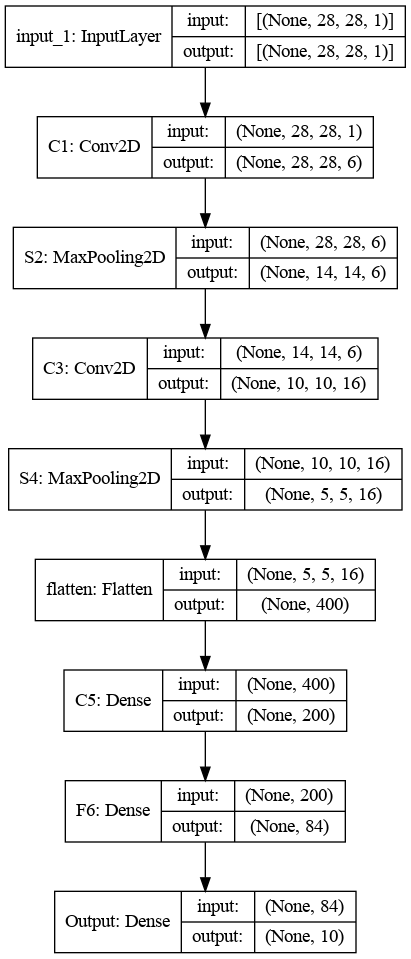

In [12]:
tf.keras.utils.plot_model(model, show_shapes=True)

### Save the initial state of the network

You can save the initial state of the weights of the untrained network (random values) with the `Model.save_weights` method. <br>
This will be useful later to reset the network to its initial state before restarting other trainings:

In [13]:
import os

# Check whether the folder 'weights' exists and cretae it if needed:
if not os.path.isdir("weights"): os.mkdir("weights")

# Save the initial DNN (random) weights:
key = 'conv-1_init'
model.save_weights(os.path.join('weights', key))

# Display the created files:
files=[os.path.join("weights",f) for f in os.listdir("weights") if f.startswith(key)]
for f in files: print(f)

weights/conv-1_init.data-00000-of-00001
weights/conv-1_init.index


Note: the `save_weights` method uses the `key` argument to prefix the created files.<br>
When loading the NDD weights later with the `load_weights` method of the `Sequential` class, just give the same key to retrieve the relevant files.

## 4 - Train the network with evaluation at each *epoch*

If necessary, consult the documentation of the `fit` method on the page [tf.keras.Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential).

Complete the cell below to train the CNN with the `fit` method of the `model` object using the arguments:
- `x_train`: the 60000 images
- `y_train`: the 60000 *one-hot* encoded labels.
- `epochs=10`: repeat full training 10 times.
- `batch_size=64`: split the input data set (the 60000 images) into "batches" of size `batch_size` (here: batches of 64 images).<br>
Updating network weights is done after batches of `batch_size` images.<br>
The value of `batch_size` (by default: 32) is a parameter that influences the quality of the training but also its memory footprint: you can later try different values (64, 128, 256 ...) and observe how the quality of the training evolves).

To have a better indicator of the quality of the trained network, you can test at each `epoch` the precision of the inferences of the trained network using the test data: just pass the `validation_data` argument to the `fit` method, assigning it the test data tuple `(x_test, y_test)`:

In [14]:
# reload the initial state of the DNN
key = 'conv-1_init'
model.load_weights(os.path.join('weights', key))

# set the seed of the random generators inolved by tensorflow:
tf.random.set_seed(SEED)

hist = model.fit(x_train, y_train,
                 validation_data=(x_test, y_test),
                 batch_size=64,
                 epochs=10)

Epoch 1/10
938/938 [==============================] - 12s 13ms/step - loss: 0.2233 - accuracy: 0.9320 - val_loss: 0.0628 - val_accuracy: 0.9800
Epoch 2/10
938/938 [==============================] - 11s 12ms/step - loss: 0.0673 - accuracy: 0.9797 - val_loss: 0.0627 - val_accuracy: 0.9787
Epoch 3/10
938/938 [==============================] - 11s 12ms/step - loss: 0.0468 - accuracy: 0.9854 - val_loss: 0.0453 - val_accuracy: 0.9847
Epoch 4/10
938/938 [==============================] - 12s 13ms/step - loss: 0.0368 - accuracy: 0.9880 - val_loss: 0.0349 - val_accuracy: 0.9879
Epoch 5/10
938/938 [==============================] - 11s 12ms/step - loss: 0.0305 - accuracy: 0.9908 - val_loss: 0.0347 - val_accuracy: 0.9887
Epoch 6/10
938/938 [==============================] - 11s 12ms/step - loss: 0.0256 - accuracy: 0.9918 - val_loss: 0.0359 - val_accuracy: 0.9882
Epoch 7/10
938/938 [==============================] - 11s 12ms/step - loss: 0.0207 - accuracy: 0.9931 - val_loss: 0.0305 - val_accuracy:

The `hist` object returned by the `fit` method has a dictionary-type `history` attribute whose keys `'loss'`, `'accuracy'` contain the evaluation of the cost function and the accuracy of the network at the end of each (*epoch*) with training data. The `'val_loss'` and `'val_accuracy'` keys are associated with test data.

In [15]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [16]:
print(hist.history['loss'])
print(hist.history['accuracy'])
print(hist.history['val_loss'])
print(hist.history['val_accuracy'])

[0.22328704595565796, 0.0672694593667984, 0.04675300791859627, 0.03677825257182121, 0.03046717494726181, 0.025556223466992378, 0.02072431705892086, 0.01748409867286682, 0.015374141745269299, 0.013024747371673584]
[0.9319999814033508, 0.9796500205993652, 0.9854000210762024, 0.9879999756813049, 0.9907500147819519, 0.9918333292007446, 0.9931166768074036, 0.9938499927520752, 0.9947500228881836, 0.9957333207130432]
[0.06279595196247101, 0.06266126036643982, 0.045282717794179916, 0.03488500043749809, 0.03474191203713417, 0.03590938821434975, 0.030532116070389748, 0.030082983896136284, 0.03724551200866699, 0.035299867391586304]
[0.9800000190734863, 0.9786999821662903, 0.9847000241279602, 0.9879000186920166, 0.9886999726295471, 0.9882000088691711, 0.9900000095367432, 0.9908999800682068, 0.9890000224113464, 0.9894999861717224]


#### Plot of `accuracy` and `loss` curves of training and testing:

The `plot_loss_accuracy` function of the `utils.tools` module (found in the notebook directory) plots accuracy and loss curves using the data stored in the `hist` object. Plot these curves:

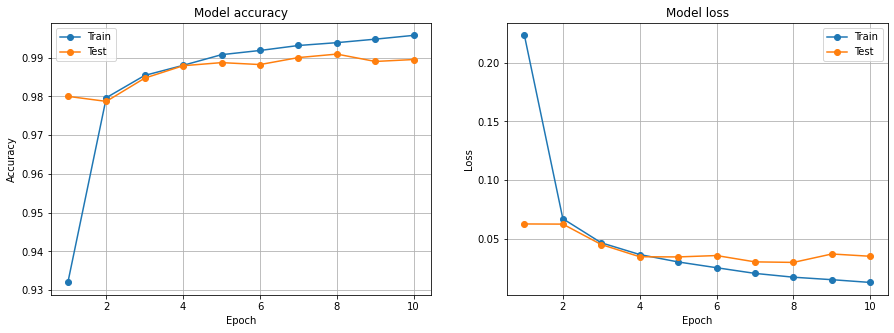

In [17]:
from utils.tools import plot_loss_accuracy
plot_loss_accuracy(hist)

## 5 - Train the network whith evaluation at each *epoch* and management of the *over-fit*

The `Keras` module offers tools to automatically stop the training by monitoring, for example, the growth of precision from one `epoch` to another.
You define the parameters of the `EarlyStopping` (cf [EarlyStopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping)) *callback* and pass it to the method `fit` via the `callbacks` argument:

Epoch 1/15
883/883 [==============================] - 11s 13ms/step - loss: 0.1807 - accuracy: 0.9435 - val_loss: 0.0656 - val_accuracy: 0.9790
Epoch 2/15
883/883 [==============================] - 11s 13ms/step - loss: 0.0568 - accuracy: 0.9830 - val_loss: 0.0435 - val_accuracy: 0.9853
Epoch 3/15
883/883 [==============================] - 11s 12ms/step - loss: 0.0407 - accuracy: 0.9878 - val_loss: 0.0404 - val_accuracy: 0.9871
Epoch 4/15
883/883 [==============================] - 11s 13ms/step - loss: 0.0318 - accuracy: 0.9898 - val_loss: 0.0297 - val_accuracy: 0.9898
Epoch 5/15
883/883 [==============================] - 12s 13ms/step - loss: 0.0260 - accuracy: 0.9913 - val_loss: 0.0348 - val_accuracy: 0.9891
Epoch 6/15
883/883 [==============================] - 11s 13ms/step - loss: 0.0215 - accuracy: 0.9931 - val_loss: 0.0329 - val_accuracy: 0.9895
Restoring model weights from the end of the best epoch.
Epoch 00006: early stopping


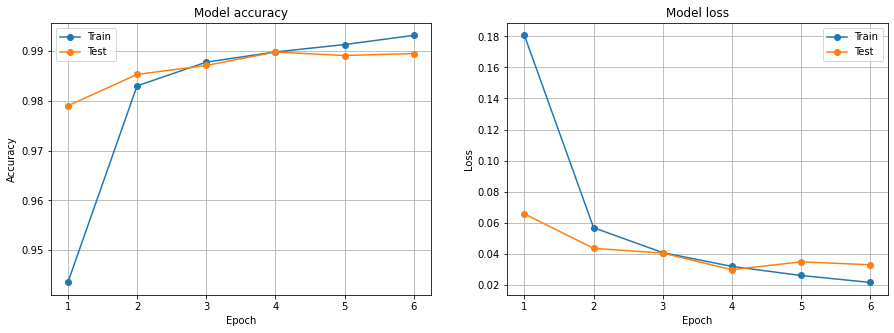

In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

callbacks_list = [ 
    EarlyStopping(monitor='val_loss',      # the parameter to monitor
                  mode='min',              # the parameter is suppose to decrese
                  patience=2,              # accept that the parameter decreases twice
                  restore_best_weights=True,
                  verbose=1)
]

# relod the DNN initial state:
key = 'conv-1_init'
model.load_weights(os.path.join('weights', key))

# set the seed of the random generators inolved by tensorflow:
tf.random.set_seed(SEED)

hist = model.fit(x_train, y_train,
                    validation_data=(x_test, y_test),
                    epochs=15, 
                    batch_size=68, 
                    callbacks = callbacks_list)

from utils.tools import plot_loss_accuracy
plot_loss_accuracy(hist)

## 6 - Save the trained CNN

The **weights** or **the structure and weights** of a trained network can be saved in a file with the `save_weights` and `save` methods of the `Sequential` class.<br><br>

### Save the weights of the trained CNN:

In [19]:
import os
# Check whether the folder 'weights' exists and create it if needed:
if not os.path.exists("weights"): os.mkdir("weights")

# save the trained CNN weights:
key = 'conv-1_trained'
model.save_weights(os.path.join('weights', key))

# Display the created files:
files=[os.path.join("weights",f) for f in os.listdir("weights") if f.startswith(key)]
for f in files: print(f)

weights/conv-1_trained.index
weights/conv-1_trained.data-00000-of-00001


### Save the weights AND structure of the trained CNN

The `save` method of the `Sequential` class saves **the structure** and the **weights** of the trained DNN<br>
You can use the `tf.keras.models.load_model` function to re-create the network later and reload its trained weights to exploit it in operational situation.

In [20]:
import os
# Check whether the folder 'models' exists and create it if needed:
if not os.path.exists("models"): os.mkdir("models")

# save the trained DNN structure + wieghts:
key = 'conv-1_trained'
model.save(os.path.join('models', key) )

# Display the created files:
files=[os.path.join("models",f) for f in os.listdir("models") if f.startswith(key)]
for f in files: print(f)

INFO:tensorflow:Assets written to: models/conv-1_trained/assets
models/conv-1_trained


The convolutional network tends towards a better accuracy close to 99%.

## 6 - Exploiting the trained network: `predict` method

The `predict` method is used to compute the CNN inferences for one or more inputs (see the `predict` method in the page 
[tf.keras.Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential#predict)).

The cell below shows an example:

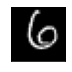

CNN inférence for the test image #100 :
[1.1019555e-05 4.1601956e-07 1.1481467e-06 9.0669282e-08 1.3884319e-05
 2.3424505e-05 9.9994469e-01 3.5247308e-07 4.6518394e-06 2.4519025e-07]


In [21]:
i = 100  # number of the test image 

# display the image:
from utils.tools import plot_images
plot_images(im_test,i,1,1) ; plt.show()

# compute the trained DNN inference inférence for tes test image:
rep = model.predict(x_test[i:i+1])      # Warning: x must be an array of matrixes, not a simple matrix
                                        # => x[i] does not work!

print(f"CNN inférence for the test image #{i} :\n{rep[0]}")

to make the output of the network more readable, we can limit the display of the numpy array to 2 decimal places:

In [22]:
with np.printoptions(formatter={'float':'{:.2f}'.format}):    
    print(f"CNN inférence for the test image #{i} rounded to 2 digits: {rep[0]}")

CNN inférence for the test image #100 rounded to 2 digits: [0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00]


The `argmax` method of the *ndarray* arrays of *numpy* gives the rank of the maximum value:

In [23]:
print(f"Predicted label is rep[0].argmax(): {rep[0].argmax()}")
print(f"True label of the test image #{i} : {lab_test[i]}")

Predicted label is rep[0].argmax(): 6
True label of the test image #100 : 6


### Usefulness of numpy's `argmax` method to decode the array of *one-hot* vectors returned by `predict`

When you compute inferences of the CNN for the images of the `x_test` array for example, you get an array of *one-hot* vectors:

In [24]:
results = model.predict(x_test)
print("shape of the 'results' ndarray:", results.shape)
print("Example of display of vectors in the 'result' ndarray:")
with np.printoptions(formatter={'float':'{:.2f}'.format}): 
    print("\tresults[0]  :", results[0])
    print("\tresults[-1] :", results[-1])

shape of the 'results' ndarray: (10000, 10)
Example of display of vectors in the 'result' ndarray:
	results[0]  : [0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00]
	results[-1] : [0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00]


With the expression `results.argmax(axe=-1)`, you get the array of the `argmax` of each vector $\leadsto$ it is the array of the digits classified by the network:

In [25]:
inferences = results.argmax(axis=-1)
print(f"inferences.shape: {inferences.shape}, inferences.dtype: {inferences.dtype}")
print(f"Content of 'inferences': {inferences}")

inferences.shape: (10000,), inferences.dtype: int64
Content of 'inferences': [7 2 1 ... 4 5 6]


We can compare `inferences` and `lab_test` with the `==` operator (this makes sense with the *ndarray* of the *numpy* module):

In [26]:
inferences == lab_test

array([ True,  True,  True, ...,  True,  True,  True])

by counting the number of `True` we get the number of correct inferences:

In [27]:
inference_ok = (inferences == lab_test)
print(f"number of true inferences: {inference_ok.sum()} over {nb_im_test} test images")

precision = inference_ok.sum()/nb_im_test*100
print(f"precision of the trained DNN: {precision:.1f} %")

number of true inferences: 9898 over 10000 test images
precision of the trained DNN: 99.0 %


## 7 - Show Confusion Matrix

The `show_cm` function from the `utils.tools` module displays the **confusion matrix** to visualize:
- on the diagonal: the correct inferences of the NN, with the number of correct answers in each box
- off diagonal: the NN errors, with in each box the number of occurrences.

In [28]:
from utils.tools import show_cm
help(show_cm)

Help on function show_cm in module utils.tools:

show_cm(true, results, classes)
    true  : the actual labels 
    results : the labels computed by the trained network)
    classes : list of possible label values



Call the `show_cm` function with arguments `lab_test`, `results` and the list of classes to display the confusion matrix:

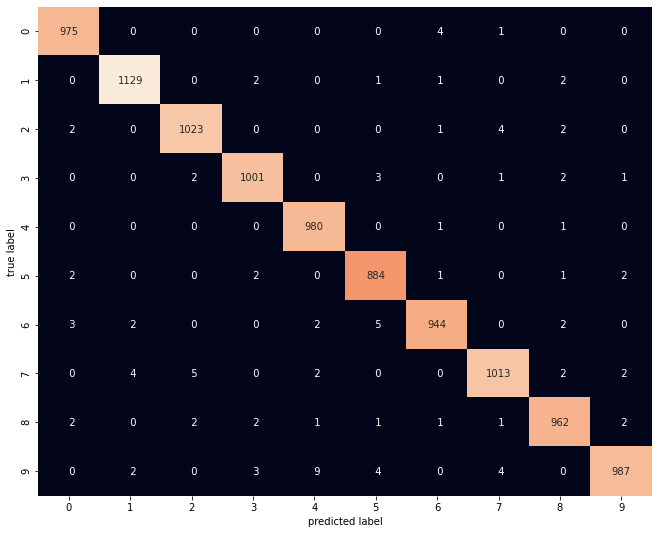

In [29]:
show_cm(lab_test, results, range(nb_class))

# Other interesting resources... videos:

In [30]:
%%HTML
<iframe src="https://www.youtube.com/embed/aircAruvnKk" width="800" height="450" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

In [31]:
%%HTML
<iframe src="https://www.youtube.com/embed/IHZwWFHWa-w" width="800" height="450" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

In [32]:
%%HTML
<iframe src="https://www.youtube.com/embed/Ilg3gGewQ5U" width="800" height="450" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>